# Daylio Data

Daylio is a mood and habit tracking app that I have used for a few years now. I have various activities that I enter with my daily mood. (There is a space for a note as well, but I don't usually use the note feature.) 

Outline for this notebook:
- Load data into a pandas dataframe
- Clean data and convert to analyzeable form
- Visualize the data to explore some basic questions:
  - What are the overall trends in the mood data?
  - What activities are associated with days with better mood?

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Load Data
Read CSV into a pandas dataframe

In [2]:
# File name of the exported file from the Daylio app
filename_daylio='daylio_export_2023_10_31.csv'

In [3]:
df_daylio = pd.read_csv(filename_daylio, parse_dates = ['full_date'])

Let's see what the data looks like:

In [4]:
df_daylio.columns

Index(['full_date', 'date', 'weekday', 'time', 'mood', 'activities',
       'note_title', 'note'],
      dtype='object')

In [5]:
df_daylio.head()

,full_date,date,weekday,time,mood,activities,note_title,note
0,2023-10-30,October 30,Monday,23:21,good,work | video chat | family,NaN,NaN
1,2023-10-29,October 29,Sunday,22:17,good,relax | gaming | church | family,NaN,NaN
2,2023-10-28,October 28,Saturday,21:02,good,friends | party | piano | video chat | family,NaN,NaN
3,2023-10-27,October 27,Friday,23:05,good,work | piano | video chat | family | walking |...,NaN,NaN
4,2023-10-26,October 26,Thursday,22:01,good,work | friends | good meal | video chat | fami...,NaN,NaN


**Notes:** The columns that I care most about will be the date, mood, and activities. However, the activities column needs to be split into different columns for each activity so it is easier to track them separately. I will also need to change the "mood" column to a number to more easily analyze it. 

## Clean data

There are a few things I want to do to clean the data to just have the parts I care about.

### Convert Mood Names to Numbers
First, I need to map the "mood" column to numeric values. 

In [6]:
df_daylio['mood'].unique()

array(['good', 'rad', 'meh', 'bad', 'Stressful', 'awful'], dtype=object)

**Notes:** The best mood ('rad') will be labeled with 5, and the worst mood ('awful') will be a 1. In the way I think about my mood, 'meh' and 'Stressful' will both be assigned a 3, since both are for days that are somewhere between 'good' and 'bad'. 

In [7]:
df_daylio['mood'] = df_daylio['mood'].map({'rad': 5, 'good': 4, 'meh': 3, 'Stressful': 3, 'bad': 2, 'awful': 1})

In [8]:
# See how many entries with different moods
df_daylio['mood'].value_counts().reset_index()

,mood,count
0,4,1164
1,3,738
2,5,123
3,2,70
4,1,11


The most common entry is 'good', least common is 'awful'. 

### List Activities Tracked
Next, I want to get a list of all of the activities tracked:

In [9]:
activities = set()
df_daylio['activities'].replace(np.nan,None,inplace=True)
for entry in df_daylio['activities']:
    if entry is not None:
        for activity in entry.split('|'):
            activities.add(activity.strip())

### Combine Multiple Entries in a Day
Finally, I know that there are some days with multiple entries. I want to combine the entries so that there is just one data point per day. I will create multiple columns for the mood mean, max, and min, in case I want to track best or worst moods, or just average moods. I will combine the activities columns from multiple entries and the note column, so that I capture everything from each day. 

In [10]:
df_daylio = df_daylio.groupby(['full_date','weekday']).aggregate(activities=('activities',lambda x: ' | '.join(x.dropna())),
                                                    mood_mean=('mood','mean'),mood_min=('mood','min'),
                                                    mood_max = ('mood','max'),
                                                    note=('note',lambda x: ' | '.join(x.dropna()))).reset_index()

### Separate Activities into Different Columns
Now I want to separate the activities into different columns, and we'll have a 0 or 1 indicating whether or not that activity was present on each day.
I will also create a column, 'num_activities', that counts how many different activities were in each day. This could help me see whether or not there is a correlation between mood and the number of activities.

In [11]:
for i in df_daylio.index:
    if df_daylio.loc[i,'activities'] is not None:
        day_activities_list = df_daylio.loc[i,'activities'].split('|')
        for activity in day_activities_list:
            df_daylio.loc[i,activity.strip()] = 1
for i in df_daylio.index:
    df_daylio.loc[i,'num_activities'] = df_daylio.loc[i,list(activities)].sum()
df_daylio.replace(np.nan,0,inplace=True)

And finally, I'll create a new column that maps names of weekdays with a number, beginning with 1 for Sunday.

In [12]:
df_daylio['weekday_num'] = df_daylio['weekday'].map(dict(zip(['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday'],list(range(1,8)))))

## Some basic visualizations

### Average Mood
What is my average mood over the past few years?

#### Basic Time Series Plot

([<matplotlib.axis.YTick at 0x113923ca0>,
 [Text(0, 1, 'Awful'),
  Text(0, 2, 'Bad'),
  Text(0, 3, 'Meh/\nStressful'),
  Text(0, 4, 'Good'),
  Text(0, 5, 'Rad')])

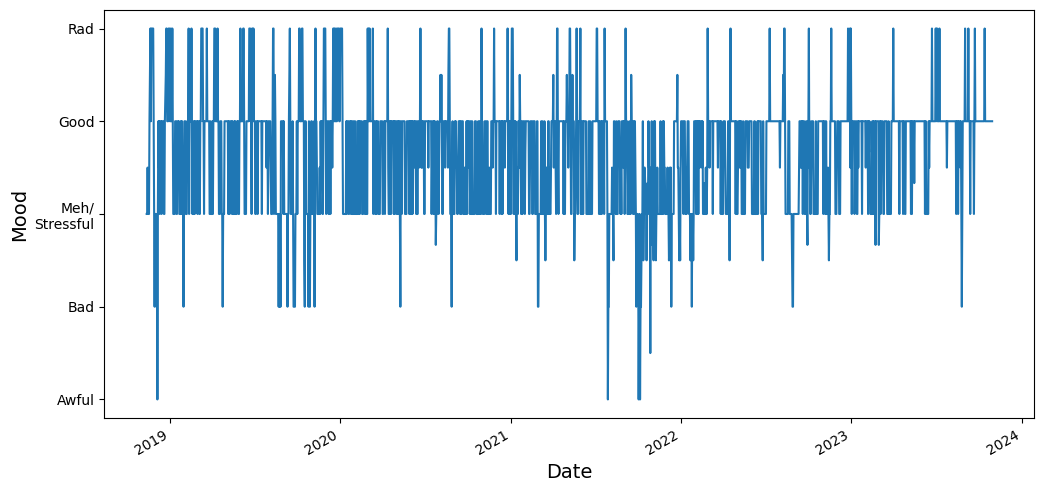

In [13]:
df_daylio.plot(x='full_date',y='mood_mean', figsize=[12,6], legend=False)
plt.ylabel('Mood',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.yticks(list(range(1,6)),labels=['Awful','Bad','Meh/\nStressful','Good','Rad'])

#### Apply Rolling Average
It's hard to see the trends with so many data points close together - let's see how a weekly rolling average makes it a bit clearer.

In [14]:
df_daylio['Weekly Rolling Average'] = df_daylio['mood_mean'].rolling(7).mean()

([<matplotlib.axis.YTick at 0x113a974f0>,
 [Text(0, 1, 'Awful'),
  Text(0, 2, 'Bad'),
  Text(0, 3, 'Meh/\nStressful'),
  Text(0, 4, 'Good'),
  Text(0, 5, 'Rad')])

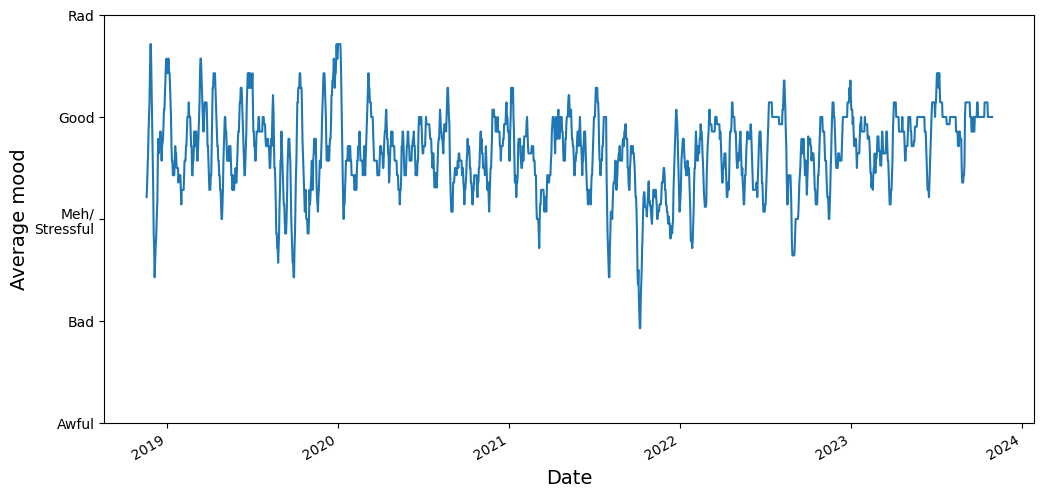

In [15]:
df_daylio.plot(x='full_date',y='Weekly Rolling Average', figsize = [12,6],legend=False)
plt.ylabel('Average mood',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.yticks(list(range(1,6)),labels=['Awful','Bad','Meh/\nStressful','Good','Rad'])

A few takeaways:
* Much easier to see the trends here! 
* There seems to be a lot more variation in 2019 than in the subsequent years (though they have their ups and downs of course). I suspect this is due to (1) the app being new to me, so I might not have been consistent yet about how I was using the app, and (2), it was a chaotic year including a cross-country move and starting a neew job.
* Overall I'm in a pretty good mood! There are very few periods where my average mood dips below "Meh"

### Mood Distribution

Text(0.5, 1.0, 'Average Mood')

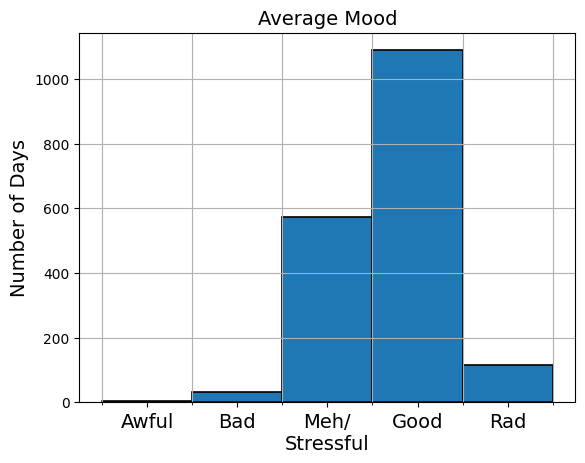

In [16]:
df_daylio.hist(column='mood_mean',bins=np.linspace(0.5,5.5,6),edgecolor='black', linewidth=1.2)
ax=plt.gca()
ax.set_xticks(np.linspace(0.5,5.5,6), minor=True)
#ax.yaxis.grid(True, which='major')
ax.xaxis.grid(True, which='minor')
ax.xaxis.grid(False,which='major')
plt.ylabel('Number of Days',fontsize=14)
plt.xticks(list(range(1,6)),labels=['Awful','Bad','Meh/\nStressful','Good','Rad'],fontsize=14)
plt.title('Average Mood',fontsize=14)

### Best Weekday
What's the best day of the week? Let's group by weekday to see if there's a pattern.

In [17]:
weekdays = df_daylio.groupby(['weekday_num','weekday']).aggregate(mood_mean=('mood_mean','mean'),
                                                            mood_std = ('mood_mean','std')).reset_index()

Text(0, 0.5, 'Average Mood')

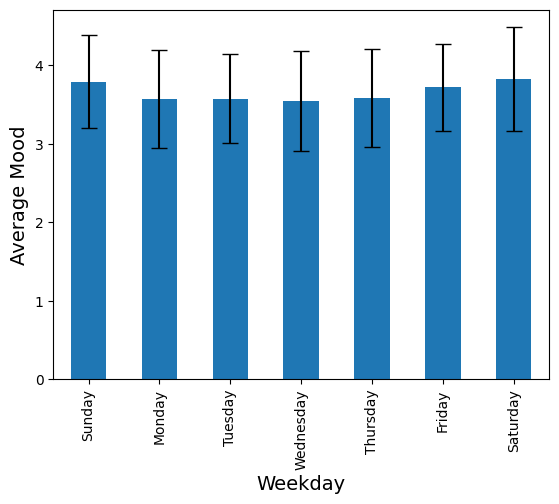

In [18]:
weekdays.plot(kind='bar',x='weekday', y='mood_mean',yerr='mood_std',capsize=6,legend=False)
plt.xlabel('Weekday',fontsize=14)
plt.ylabel('Average Mood',fontsize=14)

**Takeaway**: Weekends seem to be the best on average with the average mood dipping lower during the work week, but it should be noted that all of the days' average moods are well within one standard deviation.

### Number of Activities Recorded
Let's see about the number of activities related to the average mood.

First, what are the typical numbers of recorded activities?

In [19]:
num_act= df_daylio.groupby(['mood_mean','num_activities']).aggregate(count=('mood_mean','count')).reset_index()

Text(0, 0.5, 'Number of Activities')

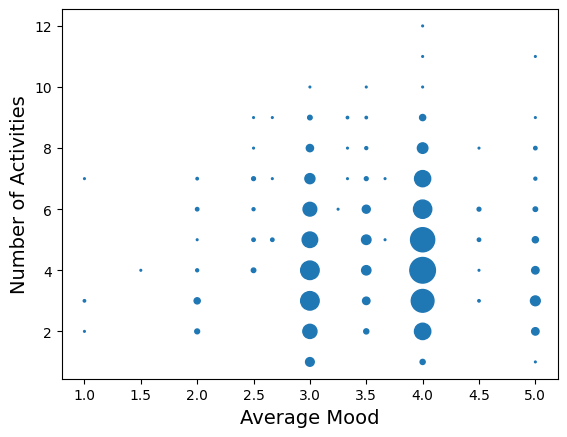

In [21]:
num_act.plot(x='mood_mean',y='num_activities',kind='scatter',s=num_act['count']*1.5)
plt.xlabel('Average Mood',fontsize=14)
plt.ylabel('Number of Activities',fontsize=14)

**Takeaway:** I don't see much correlation between the mood and number of activities listed. There are great days and not-so-great days with high and low activity counts. This isn't too surprising! I'd expect that it matters more *which* activities are listed. 

### Activities that Seem to Correlate with Mood
I'll take a look at a couple of activities to see if they seem to be correlated with my mood. 
Instead of keeping all of the exact average mood values, I'll just divide my data set into two parts: "Good days" where my average mood is better than "Meh", and "Less good days", where my average mood is "Meh" or less.

In [22]:
gooddays = df_daylio[df_daylio['mood_mean']>3]
lessgooddays = df_daylio[df_daylio['mood_mean']<=3]

In [23]:
print('Number of good days:', len(gooddays))
print('Number of less good days:', len(lessgooddays))

Number of good days: 1208
Number of less good days: 603


In [24]:
for activity in activities:
    percent_gooddays = gooddays[activity].sum()/gooddays['full_date'].count()
    if percent_gooddays>0.01:
        percent_lessgooddays = lessgooddays[activity].sum()/lessgooddays['full_date'].count()
        ratio = percent_gooddays/percent_lessgooddays
        if (ratio >3):
            print(activity.upper(),'occurs %.1f' %(ratio),'times as often on GOOD days')
        elif (ratio < .33):
            print(activity.upper(),'occurs %.1f' %(1/ratio),'times as often on LESS good days')

CRYING occurs 5.8 times as often on LESS good days
PARTY occurs 8.2 times as often on GOOD days
FEELING SICK occurs 4.4 times as often on LESS good days
CHRISTMAS EVENT occurs 8.5 times as often on GOOD days
GOOD MEAL occurs 3.4 times as often on GOOD days
ADVENTURE occurs 4.6 times as often on GOOD days


### Work vs Non Work Days

In [25]:
workdays = df_daylio[df_daylio['work']==1]
nonworkdays = df_daylio[df_daylio['work']==0]

([<matplotlib.axis.XTick at 0x113deca90>,
 [Text(1.5, 0, 'Awful'),
  Text(2.5, 0, 'Bad'),
  Text(3.5, 0, 'Meh/\nStressful'),
  Text(4.5, 0, 'Good'),
  Text(5.5, 0, 'Rad')])

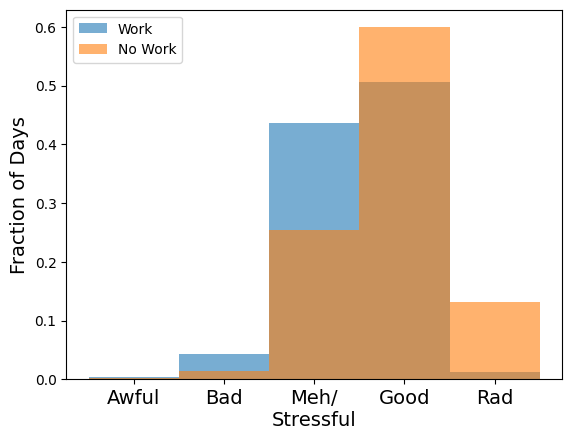

In [26]:
plt.hist(workdays['mood_mean'],density=True,bins=np.linspace(1,6,6),alpha=0.6,label='Work')
ax=plt.gca()
ax.hist(nonworkdays['mood_mean'],density=True,bins=np.linspace(1,6,6),alpha=0.6, label='No Work')
plt.legend()
plt.ylabel('Fraction of Days', fontsize=14)
plt.xticks(np.linspace(1.5,5.5,5),labels=['Awful','Bad','Meh/\nStressful','Good','Rad'],fontsize=14)

Work days tend to be more "meh/stressful", although there are still a significant number of good days! Days with no work are a bit more likely to be "good" or "rad".

### Family 

In [32]:
family = df_daylio[df_daylio['family']==1]
nofamily = df_daylio[df_daylio['family']==0]

([<matplotlib.axis.XTick at 0x114364fd0>,
 [Text(1.5, 0, 'Awful'),
  Text(2.5, 0, 'Bad'),
  Text(3.5, 0, 'Meh/\nStressful'),
  Text(4.5, 0, 'Good'),
  Text(5.5, 0, 'Rad')])

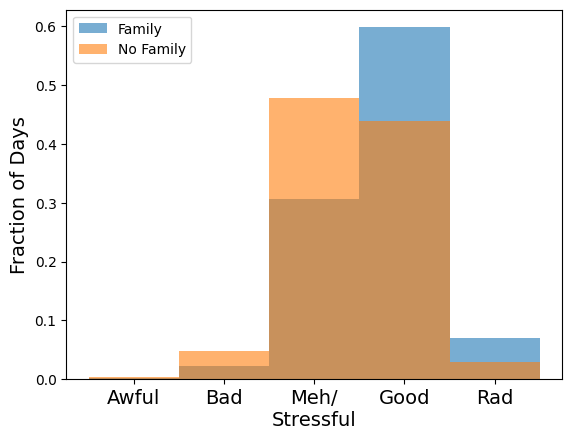

In [33]:
plt.hist(family['mood_mean'],density=True,bins=np.linspace(1,6,6),alpha=0.6,label='Family')
ax=plt.gca()
ax.hist(nofamily['mood_mean'],density=True,bins=np.linspace(1,6,6),alpha=0.6, label='No Family')
plt.legend()
plt.ylabel('Fraction of Days', fontsize=14)
plt.xticks(np.linspace(1.5,5.5,5),labels=['Awful','Bad','Meh/\nStressful','Good','Rad'],fontsize=14)

Unsurprisingly, days where I have family interactions tend to be associated with a better mood! **But it should be noted**: for most of the last few years, being at work meant more time away from family since I lived in another state (except through video chat). So really, the past two histograms are not completely independent. The fact that the distribution is towards a better mood on non-work days could be because those days are more likely to be associated with family. (Or alternatively, maybe family days are more positive because they're more likely to be days when I'm not working!) This shows some limitations of this analysis, so I could extend this further to try to distinguish between the two causes (e.g. look at work days with and without family).

## Notes for Future Work

Some possibilities for future exploration:
- Create a box plot to show mood distributions of more activities together
- Try to distinguish between effects of multiple activities (e.g. see note above about work/family)
- Correlate moods and habits with data from other apps (e.g. location history, activity tracker)
